In [3]:
import os
import shutil
import random

# Paths
source_folder = "sec10"
train_folder = "train"
test_folder = "test"

# Create train and test folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Iterate over each folder inside the source folder
for folder_name in os.listdir(source_folder):
    folder_path = os.path.join(source_folder, folder_name)
    
    # Ensure it's a directory
    if os.path.isdir(folder_path):
        # Get all audio files in the folder
        audio_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        random.shuffle(audio_files)
        
        # Split files into 80% train and 20% test
        split_index = int(len(audio_files) * 0.8)
        train_files = audio_files[:split_index]
        test_files = audio_files[split_index:]
        
        # Create corresponding subfolders in train and test directories
        train_subfolder = os.path.join(train_folder, folder_name)
        test_subfolder = os.path.join(test_folder, folder_name)
        os.makedirs(train_subfolder, exist_ok=True)
        os.makedirs(test_subfolder, exist_ok=True)
        
        # Move files to train folder
        for file_name in train_files:
            shutil.copy(os.path.join(folder_path, file_name), os.path.join(train_subfolder, file_name))
        
        # Move files to test folder
        for file_name in test_files:
            shutil.copy(os.path.join(folder_path, file_name), os.path.join(test_subfolder, file_name))

print("Files have been split into train and test folders.")


Files have been split into train and test folders.


In [1]:
import os
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pickle


In [2]:
# Paths
train_folder = "train"  # Path to your train folder

# Initialize lists
features = []
labels = []

# Function to extract manual features
def extract_manual_features(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=None)
        
        # Extract Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(audio)
        zcr_mean = np.mean(zcr)
        
        # Extract Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
        spectral_centroid_mean = np.mean(spectral_centroid)
        
        # Extract Chroma Feature
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        chroma_mean = np.mean(chroma)
        
        # Extract MFCC (Mel-Frequency Cepstral Coefficients)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc.T, axis=0)
        
        # Extract Root Mean Square (RMS) Energy
        rms = librosa.feature.rms(y=audio)
        rms_mean = np.mean(rms)
        
        # Return all features as a single array
        return [zcr_mean, spectral_centroid_mean, chroma_mean] + list(mfcc_mean) + [rms_mean]
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Loop through folders
for folder_name in os.listdir(train_folder):
    folder_path = os.path.join(train_folder, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if file_name.endswith(".wav"):  # Ensure only .wav files are processed
                feature = extract_manual_features(file_path)
                if feature is not None:
                    features.append(feature)
                    labels.append(folder_name)

# Encode labels
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

# Standardize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Now features and labels are ready for training


c:\Users\Asus\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [3]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [4]:
# Train an SVM Classifier
svm_model = SVC(kernel='linear', random_state=42)  # You can try 'rbf' kernel for non-linear problems
svm_model.fit(features, encoded_labels)

# Save the model and encoder for future use
with open("lung_sound_svm_model.pkl", "wb") as model_file:
    pickle.dump(svm_model, model_file)

with open("label_encoder.pkl", "wb") as encoder_file:
    pickle.dump(encoder, encoder_file)

# Save the scaler for future use
with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)

print("SVM Model training complete and saved.")


SVM Model training complete and saved.


Accuracy:  0.5394190871369294

Classification Report:
                precision    recall  f1-score   support

     asthmaout       0.50      0.60      0.54        72
       bronout       1.00      1.00      1.00         4
       copdout       0.62      0.38      0.47        21
   effusionout       0.00      0.00      0.00         4
   fibrosisout       1.00      0.29      0.44         7
heartfailurout       0.47      0.21      0.29        43
     normalout       0.53      0.74      0.62        81
  pneumoniaout       1.00      0.44      0.62         9

      accuracy                           0.54       241
     macro avg       0.64      0.46      0.50       241
  weighted avg       0.55      0.54      0.52       241


Confusion Matrix:
[[43  0  0  0  0  3 26  0]
 [ 0  4  0  0  0  0  0  0]
 [ 8  0  8  0  0  0  5  0]
 [ 1  0  0  0  0  0  3  0]
 [ 4  0  0  0  2  0  1  0]
 [15  0  1  0  0  9 18  0]
 [11  0  4  0  0  6 60  0]
 [ 4  0  0  0  0  1  0  4]]


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


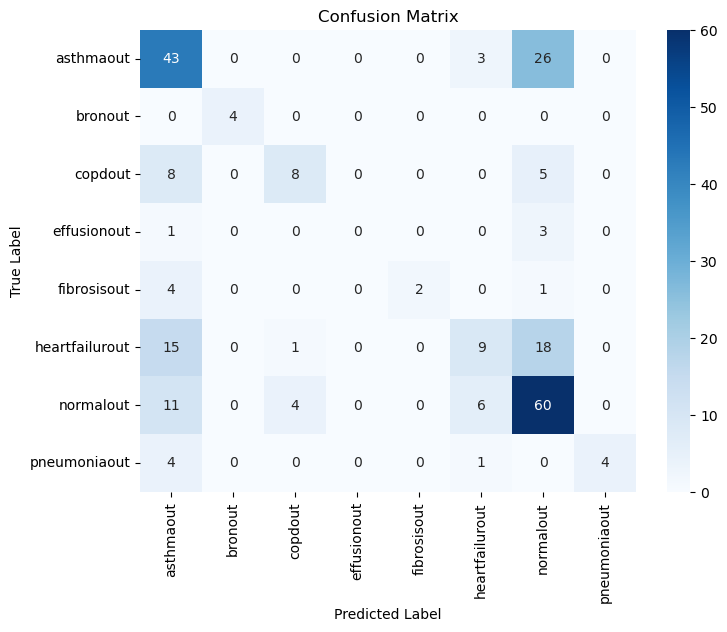

In [21]:
def evaluate_model(features, labels):
    # Load the model and encoder
    with open("lung_sound_svm_model.pkl", "rb") as model_file:
        model = pickle.load(model_file)
    with open("label_encoder.pkl", "rb") as encoder_file:
        encoder = pickle.load(encoder_file)
    
    # Make predictions
    predictions = model.predict(features)
    
    # Decode the predictions
    decoded_predictions = encoder.inverse_transform(predictions)
    decoded_labels = encoder.inverse_transform(labels)
    
    # Calculate Accuracy
    accuracy = accuracy_score(decoded_labels, decoded_predictions)
    print("Accuracy: ", accuracy)
    
    # Generate and display classification report
    print("\nClassification Report:")
    print(classification_report(decoded_labels, decoded_predictions))
    
    # Generate confusion matrix
    cm = confusion_matrix(decoded_labels, decoded_predictions)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model with the training data
evaluate_model(features, encoded_labels)


In [23]:

def predict(file_path):
    # Load model, encoder, and scaler
    with open("lung_sound_svm_model.pkl", "rb") as model_file:
        model = pickle.load(model_file)
    with open("label_encoder.pkl", "rb") as encoder_file:
        encoder = pickle.load(encoder_file)
    with open("scaler.pkl", "rb") as scaler_file:
        scaler = pickle.load(scaler_file)
    
    # Extract features
    feature = extract_manual_features(file_path)
    if feature is None:
        return "Error extracting features from audio."
    
    # Standardize features
    feature = scaler.transform([feature])
    
    # Predict
    prediction = model.predict(feature)
    class_name = encoder.inverse_transform(prediction)
    return class_name[0]


In [25]:
file_path='F:/EEEProject/test/asthmaout/BP68_asthma,E W,P R L ,21,F_middle10sec.wav'
value=predict(file_path)
value

c:\Users\Asus\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


'normalout'